In [1]:
#Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(10,4)}
        )

In [3]:
#Загружаем данные
df = pd.read_csv('hw_bootstrap.csv', sep=';', index_col='Unnamed: 0')

Прежде чем приступать к заданию изучим наши данные

In [4]:
df.head()

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   value              1000 non-null   object
 1   experimentVariant  1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [6]:
#Преобразуем значения нашей метрики во float
df['value'] = df['value'].apply(lambda x: float(x.replace(',','.')))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


In [8]:
df.experimentVariant.value_counts()

Treatment    500
Control      500
Name: experimentVariant, dtype: int64

Разделим данные на 2 датафрейма по группам и детальнее посмотрим на них. 

In [9]:
df_control = df.query('experimentVariant == "Control"')

In [10]:
df_treatment = df.query('experimentVariant == "Treatment"')

In [11]:
df_control.describe()

,value
count,500.000000
mean,10.026867
std,0.979377
min,6.436541
25%,9.411024
50%,10.018465
75%,10.664879
max,13.130346


In [12]:
df_treatment.describe()

,value
count,500.000000
mean,27.321499
std,186.557011
min,6.436541
25%,9.421968
50%,10.025847
75%,10.675721
max,3000.000000


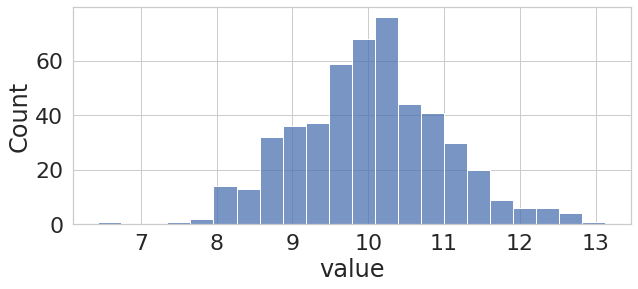

In [13]:
sns.histplot(data=df_control, x='value');

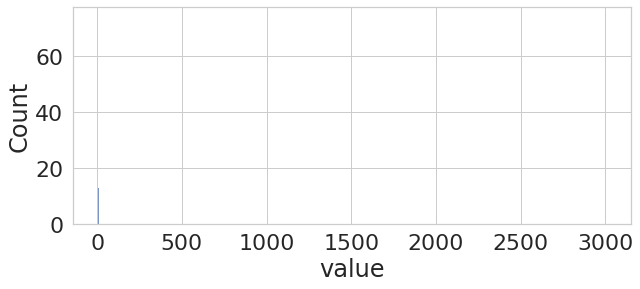

In [14]:
sns.histplot(data=df_treatment, x='value');

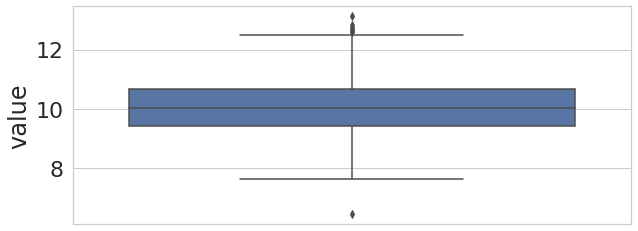

In [15]:
sns.boxplot(y=df_control['value']);

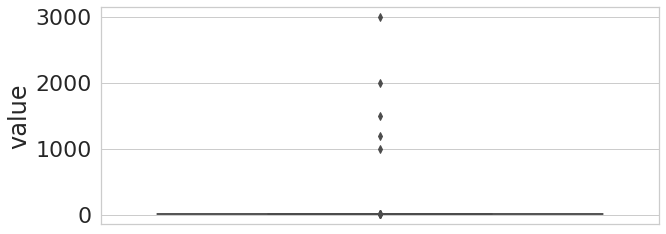

In [16]:
sns.boxplot(y=df_treatment['value']);

## Выводы о данных

- Объемы выборок равны
- Метрика в группе control распределена практически нормально
- Метрика в группе treatment распределена не нормально, имеет длинный правый хвост

## Задача

1. Сравните результат между тестом и контролем по двум кейсам:

    - Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
    - Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.

2. Напишите выводы, которые можно сделать на основе анализа примененных критериев



In [17]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

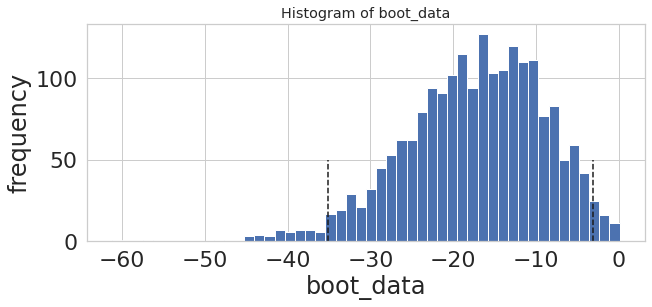

In [18]:
# Применим бутстрап с np.mean
booted_data_mean = get_bootstrap(
    df_control['value'], # числовые значения первой выборки
    df_treatment['value'], # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [19]:
booted_data_mean["p_value"]

0.03747322860595284

In [20]:
booted_data_mean["ci"]

,0
0.025,-35.185390
0.975,-3.105464


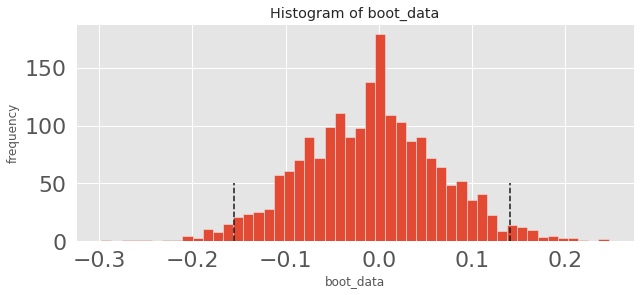

In [21]:
# Применим бутстрап с np.median
booted_data_median = get_bootstrap(
    df_control['value'], # числовые значения первой выборки
    df_treatment['value'], # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [22]:
booted_data_median["p_value"]

0.8996467736591534

In [23]:
booted_data_median["ci"]

,0
0.025,-0.155216
0.975,0.140732


In [24]:
# Применим критерий mann-whitney
mannwhitneyu(df_control['value'], df_treatment['value'])

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

## Выводы

- Бутстрап с np.mean показывет pvalue < 0.05, но 0 не попадает в доверительный 95% интервал
- Бутстрап с np.median показывет pvalue > 0.05, 0 попадает в доверительный 95% интервал
- Критарий Манн-Уитни показывет pvalue > 0.05

**Бутстрап с средним чувствителен к выбросам, что мешает оставить Н0.**

**Бутстрап с медианой не чувтвителен к выбросам так же, как и критерий Манн-Уитни. Они позволяют принять нам Н0. 
При таких или схожих распределений данных нужно пользоваться ими.**

**Следовательно, разница метрики в выборках не статистически значима.**